# # Physical Constraint Check: BC=0 when Fabs=0
# 
# This notebook recreates the "Physical Constraint Check" plot that demonstrates
# which MAC calculation methods violate the physical constraint that Black Carbon
# should equal zero when light absorption (Fabs) equals zero.
# 
# **Key Question**: Should BC = 0 when Fabs = 0?
# - Methods without intercepts: YES (passes through origin)
# - Method 3 with intercept: NO (predicts BC > 0 even when Fabs = 0)

In [2]:
import os
import sys
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
import pandas as pd

cwd = Path.cwd().resolve()
repo_root = next((p for p in [cwd, *cwd.parents] if (p / 'pyproject.toml').exists()), cwd)
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

data_root = Path(
    os.environ.get('AETHMODULAR_DATA_ROOT', str(repo_root / 'research' / 'ftir_hips_chem'))
).expanduser().resolve()

from src.data.loaders.aethalometer_filter_matcher import AethalometerFilterMatcher

# Set publication-quality plotting parameters
plt.rcParams.update({
    'figure.figsize': [14, 10],
    'font.size': 14,
    'axes.labelsize': 18,
    'axes.titlesize': 20,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 14,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight'
})

In [3]:
# CONFIGURATION - UPDATE THESE FOR YOUR DATA
AETHALOMETER_PATH = str((data_root / 'df_Jacros_9am_resampled.pkl').resolve())
FILTER_DB_PATH = str((data_root / 'Filter Data' / 'unified_filter_dataset.pkl').resolve())
SITE_CODE = "ETAD"  # Update this to your site code

print("Loading data...")

Loading data...


In [4]:
def load_data_for_site(aethalometer_path, filter_db_path, site_code):
    """
    Load HIPS Fabs, FTIR EC, and Aethalometer BCc data for a specific site
    """
    
    # Create matcher and load data
    matcher = AethalometerFilterMatcher(aethalometer_path, filter_db_path)
    
    # Match site data - NOW INCLUDING AETHALOMETER
    matched_data = matcher.match_site_data(
        site_code,
        filter_parameters=['EC_ftir', 'HIPS_Fabs'],
        aethalometer_columns=['IR BCc smoothed']  # ← ADD THIS
    )
    
    # Filter to valid samples
    valid_cols = ['EC_ftir', 'HIPS_Fabs', 'IR BCc smoothed']
    valid_mask = matched_data[valid_cols].notna().any(axis=1)  # At least one measurement
    df_clean = matched_data.loc[valid_mask, ['datetime_local', 'match_date'] + valid_cols].copy()
    
    # Rename columns
    df_clean = df_clean.rename(columns={
        'EC_ftir': 'ec_ftir',
        'HIPS_Fabs': 'fabs',
        'IR BCc smoothed': 'ir_bcc'  # ← ADD THIS
    })
    
    print(f"\n{'='*70}")
    print(f"DATA LOADED FOR SITE: {site_code}")
    print(f"{'='*70}")
    print(f"Total matched samples: {len(matched_data)}")
    print(f"Samples with EC and HIPS: {df_clean[['ec_ftir', 'fabs']].notna().all(axis=1).sum()}")
    print(f"Samples with Aethalometer: {df_clean['ir_bcc'].notna().sum()}")
    print(f"Date range: {df_clean['match_date'].min()} to {df_clean['match_date'].max()}")
    
    return df_clean

# Reload the data with aethalometer included
df = load_data_for_site(AETHALOMETER_PATH, FILTER_DB_PATH, SITE_CODE)

Loading complete filter dataset from ../research/ftir_hips_chem/Filter Data/unified_filter_dataset.pkl...
Dataset loaded successfully!
   Total measurements: 44,493
   Unique filters: 1,603
   Sites: CHTS, ETAD, INDH, USPA
   Date range: 2013-06-28 to 2024-12-08
   Data sources: ChemSpec, FTIR, HIPS
✅ Filter database loaded from: ../research/ftir_hips_chem/Filter Data/unified_filter_dataset.pkl
🔗 Matching aethalometer and filter data for ETAD...
✅ Aethalometer data loaded from: ../research/ftir_hips_chem/df_Jacros_9am_resampled.pkl
   Dataset shape: (1047, 320)
   Date range: 2022-04-13 09:00:00+03:00 to 2025-06-25 09:00:00+03:00
   No 'Site' column found - assuming single site data
📍 No 'Site' column - assuming all data is for ETAD
📂 Extracting ETAD filter measurements...
   ✅ EC_ftir: 190 measurements
      Date range: 2022-12-07 to 2024-09-21
   ✅ HIPS_Fabs: 190 measurements
      Date range: 2022-12-07 to 2024-09-21

✅ Combined filter dataset: (192, 3)
   Date range: 2022-12-07 to 

# ## Configuration and Data Loading
# 
# Update these parameters for your specific dataset and site.

# ## Calculate MAC Using All 4 Methods
# 
# We'll calculate the Mass Absorption Cross-section (MAC) using four different methods:
# 
# 1. **Method 1**: Mean of individual Fabs/EC ratios
# 2. **Method 2**: Ratio of mean Fabs to mean EC
# 3. **Method 3**: Standard linear regression (with intercept) - **Has intercept issue**
# 4. **Method 4**: Linear regression through origin (no intercept)

In [5]:
def calculate_all_mac_methods(df):
    """
    Calculate MAC values using all 4 methods
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Must contain 'ec_ftir' and 'fabs' columns
        
    Returns:
    --------
    dict : Dictionary containing MAC values, intercepts, and metadata for each method
    """
    
    ec_original = df['ec_ftir'].values
    fabs_original = df['fabs'].values
    
    print(f"\n{'='*80}")
    print(f"CALCULATING MAC VALUES FOR ALL METHODS")
    print(f"{'='*80}")
    print(f"Number of samples: {len(ec_original)}")
    print(f"EC range: {ec_original.min():.2f} - {ec_original.max():.2f} μg/m³")
    print(f"Fabs range: {fabs_original.min():.2f} - {fabs_original.max():.2f} Mm⁻¹")
    
    # Method 1: Mean of individual ratios
    individual_mac = df['fabs'] / df['ec_ftir']
    mac_method1 = individual_mac.mean()
    
    # Method 2: Ratio of means
    mac_method2 = df['fabs'].mean() / df['ec_ftir'].mean()
    
    # Method 3: Standard regression (WITH INTERCEPT)
    reg_standard = LinearRegression(fit_intercept=True)
    reg_standard.fit(ec_original.reshape(-1, 1), fabs_original)
    mac_method3 = reg_standard.coef_[0]
    intercept_method3 = reg_standard.intercept_
    
    # Method 4: Origin regression (NO INTERCEPT)
    reg_origin = LinearRegression(fit_intercept=False)
    reg_origin.fit(ec_original.reshape(-1, 1), fabs_original)
    mac_method4 = reg_origin.coef_[0]
    
    # Calculate BC equivalent lines for plotting
    fabs_range = np.linspace(0, fabs_original.max() * 1.2, 100)
    
    # Store all results
    results = {
        'ec_original': ec_original,
        'fabs_original': fabs_original,
        'fabs_range': fabs_range,
        'methods': {
            'Method 1: Mean of Ratios': {
                'mac': mac_method1,
                'intercept': 0,
                'color': '#e74c3c',
                'bc_line': fabs_range / mac_method1,
                'bc_at_zero_fabs': 0
            },
            'Method 2: Ratio of Means': {
                'mac': mac_method2,
                'intercept': 0,
                'color': '#27ae60',
                'bc_line': fabs_range / mac_method2,
                'bc_at_zero_fabs': 0
            },
            'Method 3: Standard Regression': {
                'mac': mac_method3,
                'intercept': intercept_method3,
                'color': '#3498db',
                'bc_line': np.maximum(fabs_range - intercept_method3, 0) / mac_method3,
                'bc_at_zero_fabs': -intercept_method3 / mac_method3
            },
            'Method 4: Origin Regression': {
                'mac': mac_method4,
                'intercept': 0,
                'color': '#9b59b6',
                'bc_line': fabs_range / mac_method4,
                'bc_at_zero_fabs': 0
            }
        }
    }
    
    # Print summary
    print(f"\n{'='*80}")
    print(f"MAC VALUES SUMMARY")
    print(f"{'='*80}")
    
    for i, (method_name, data) in enumerate(results['methods'].items(), 1):
        print(f"\nMethod {i}: {method_name}")
        print(f"  MAC = {data['mac']:.3f} m²/g")
        print(f"  Intercept = {data['intercept']:.3f} Mm⁻¹")
        print(f"  BC when Fabs=0: {data['bc_at_zero_fabs']:.3f} μg/m³")
        
        if abs(data['bc_at_zero_fabs']) > 0.01:
            print(f"  ⚠️  VIOLATES physical constraint (BC ≠ 0 when Fabs = 0)")
        else:
            print(f"  ✅ SATISFIES physical constraint (BC = 0 when Fabs = 0)")
    
    return results

# Calculate MAC for all methods
results = calculate_all_mac_methods(df)


CALCULATING MAC VALUES FOR ALL METHODS
Number of samples: 175
EC range: 0.69 - 11.74 μg/m³
Fabs range: 28.09 - 85.85 Mm⁻¹

MAC VALUES SUMMARY

Method 1: Method 1: Mean of Ratios
  MAC = 11.008 m²/g
  Intercept = 0.000 Mm⁻¹
  BC when Fabs=0: 0.000 μg/m³
  ✅ SATISFIES physical constraint (BC = 0 when Fabs = 0)

Method 2: Method 2: Ratio of Means
  MAC = 9.606 m²/g
  Intercept = 0.000 Mm⁻¹
  BC when Fabs=0: 0.000 μg/m³
  ✅ SATISFIES physical constraint (BC = 0 when Fabs = 0)

Method 3: Method 3: Standard Regression
  MAC = 4.025 m²/g
  Intercept = 28.538 Mm⁻¹
  BC when Fabs=0: -7.090 μg/m³
  ⚠️  VIOLATES physical constraint (BC ≠ 0 when Fabs = 0)

Method 4: Method 4: Origin Regression
  MAC = 8.631 m²/g
  Intercept = 0.000 Mm⁻¹
  BC when Fabs=0: 0.000 μg/m³
  ✅ SATISFIES physical constraint (BC = 0 when Fabs = 0)


# ## Create the Physical Constraint Check Plot
# 
# This plot demonstrates which methods violate the physical expectation that
# BC should equal zero when light absorption (Fabs) equals zero.
# 
# **Key Features**:
# - Solid lines: Methods that satisfy the constraint (pass through origin)
# - Dashed lines: Methods with intercepts (violate the constraint)
# - Red shaded region: Where Method 3 predicts BC > 0 despite Fabs = 0

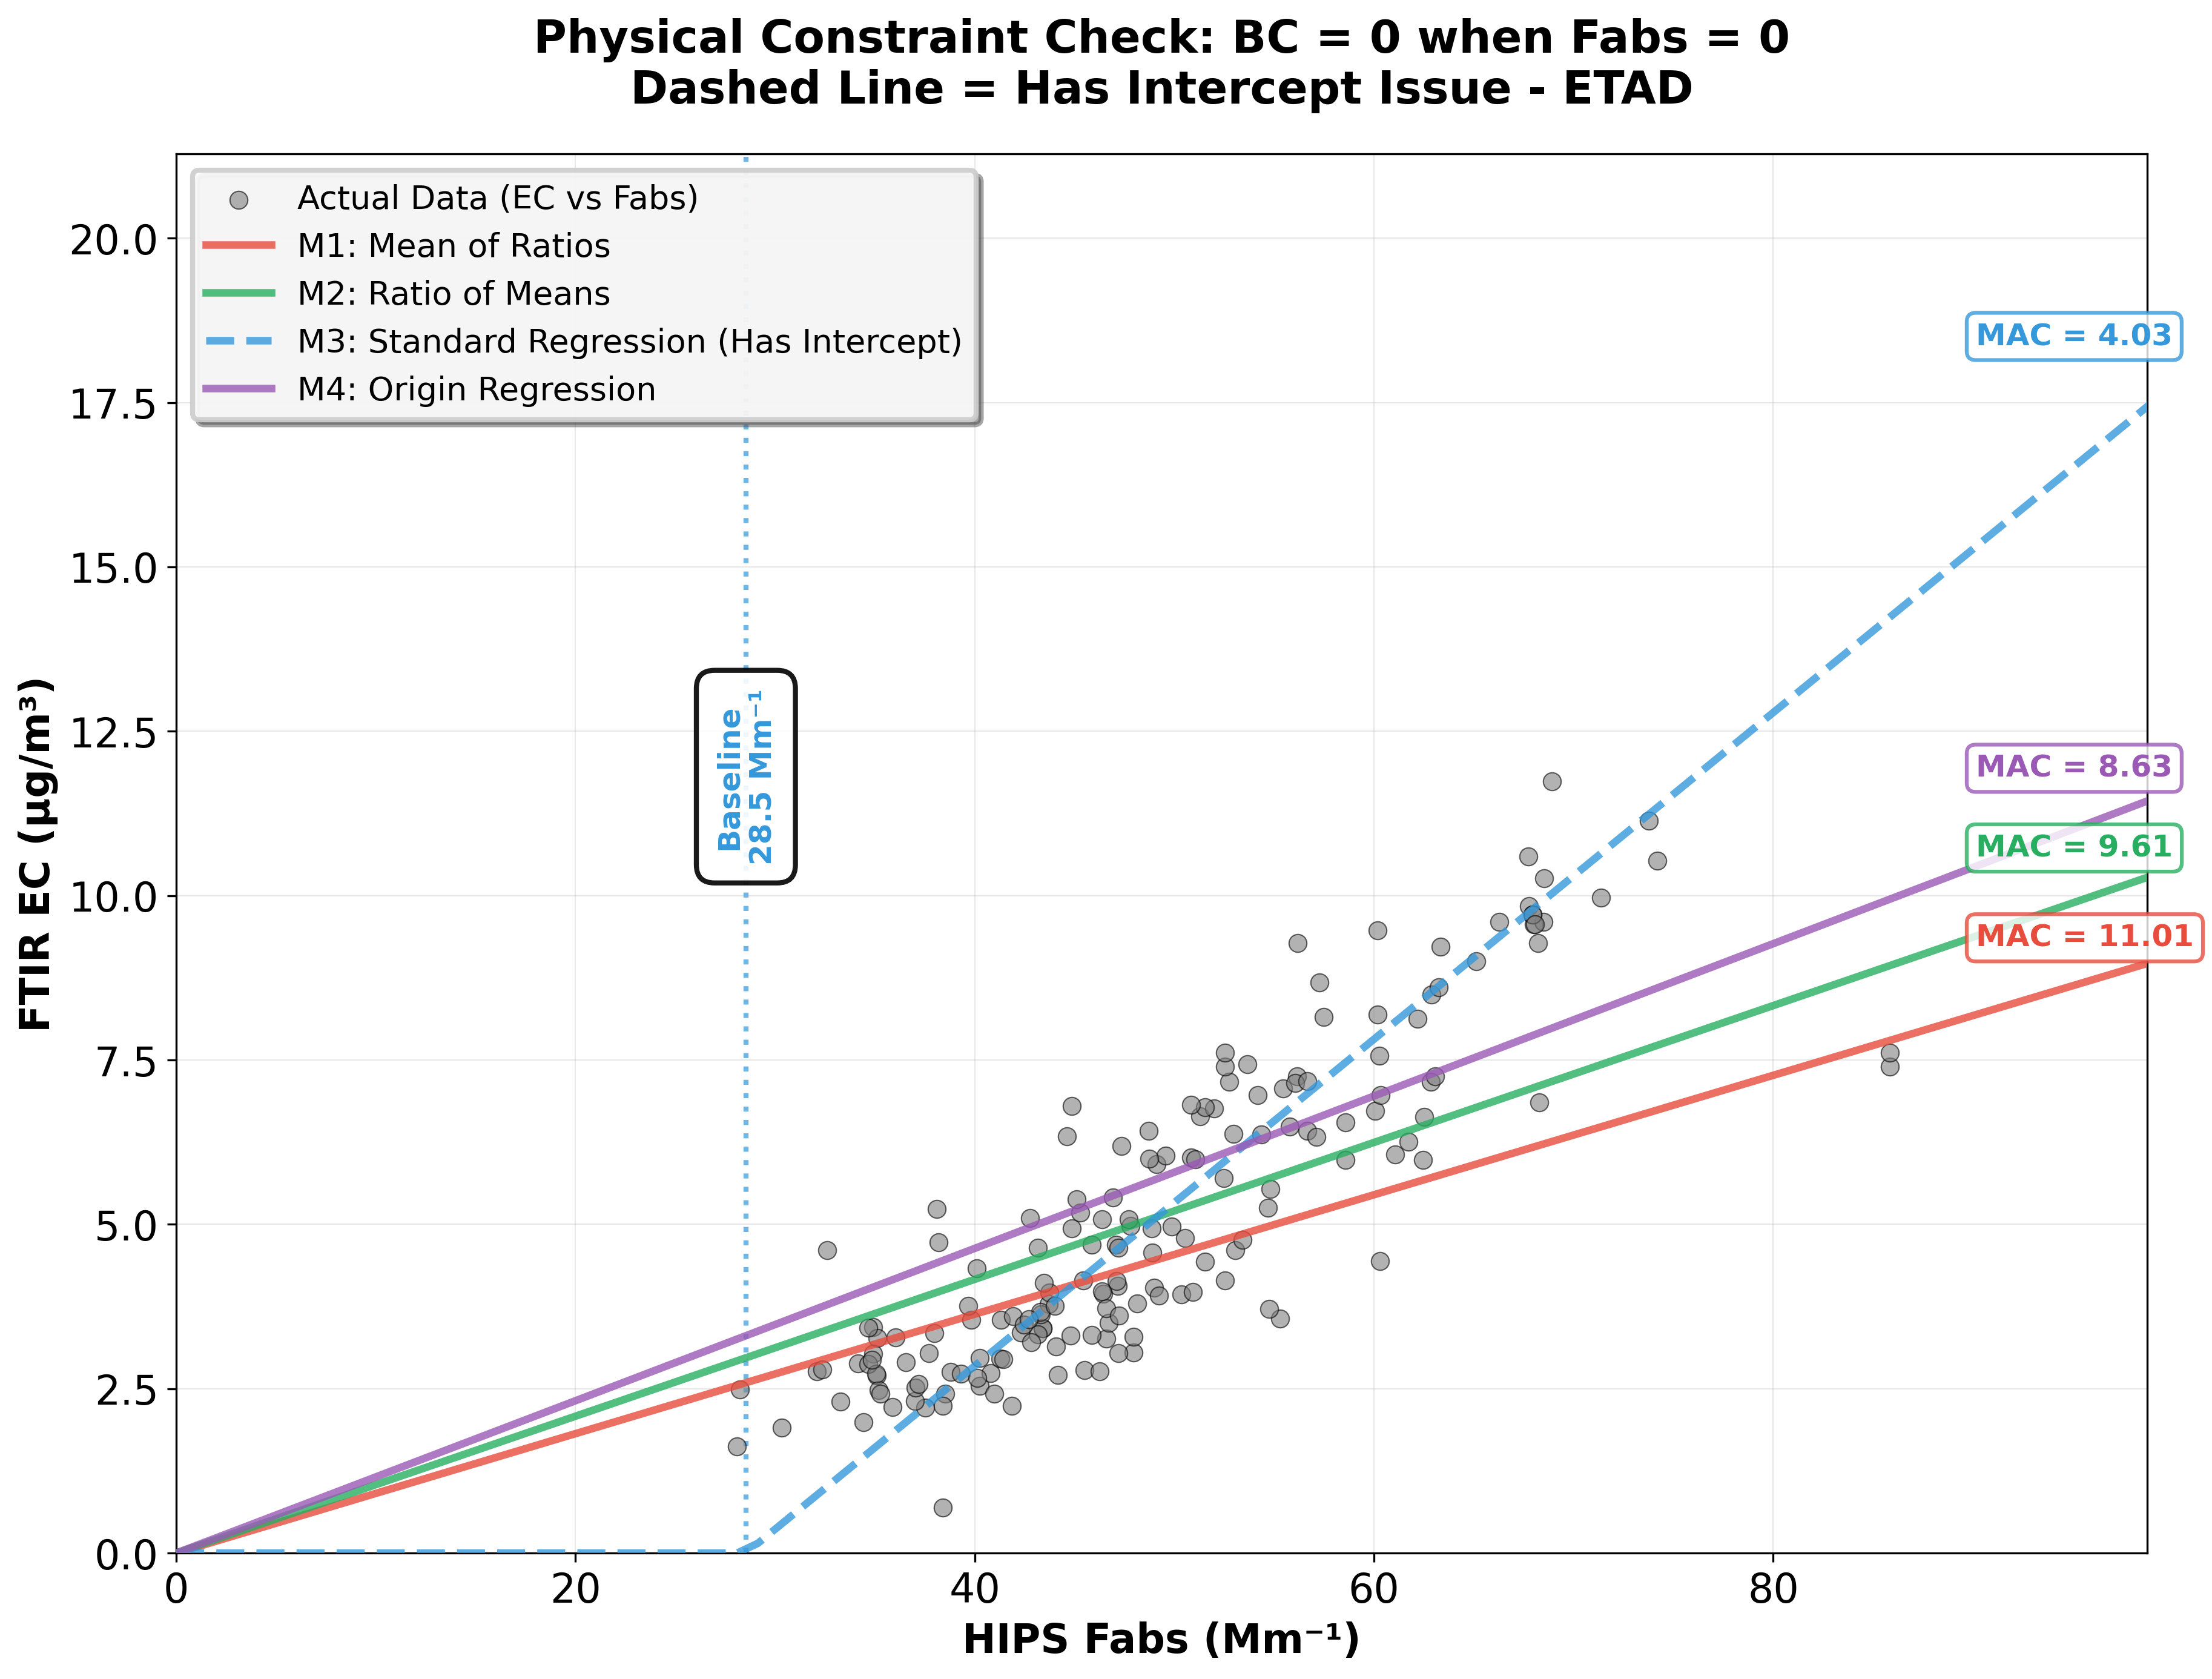

In [6]:
def plot_physical_constraint_check(results, site_code='ETAD'):
    """
    Create the physical constraint check plot
    
    Shows BC equivalent vs Fabs for all methods, highlighting which methods
    violate the constraint that BC should equal zero when Fabs equals zero.
    """
    
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Extract data
    ec_data = results['ec_original']
    fabs_data = results['fabs_original']
    fabs_range = results['fabs_range']
    
    # Plot actual data points
    ax.scatter(fabs_data, ec_data, alpha=0.6, s=50, color='gray', 
               label='Actual Data (EC vs Fabs)', zorder=2, edgecolors='black', linewidth=0.5)
    
    # Track which methods have intercepts for the legend
    has_intercept_shown = False
    
    # Plot BC equivalent lines for each method
    for i, (method_name, data) in enumerate(results['methods'].items(), 1):
        method_short = f"M{i}"
        
        if data['intercept'] != 0:
            # Method with intercept - show as DASHED line
            linestyle = '--'
            linewidth = 3
            alpha = 0.8
            
            ax.plot(fabs_range, data['bc_line'], 
                   color=data['color'], linewidth=linewidth, linestyle=linestyle,
                   alpha=alpha, label=f"{method_short}: {method_name.split(':')[1].strip()} (Has Intercept)",
                   zorder=3)
            
            # Highlight the intercept issue with vertical line
            ax.axvline(x=data['intercept'], color=data['color'], linestyle=':', 
                      alpha=0.7, linewidth=2, zorder=1)
            
            # Add annotation for the intercept
            ax.text(data['intercept'], max(ec_data) * 0.9, 
                   f"Baseline\n{data['intercept']:.1f} Mm⁻¹", 
                   ha='center', rotation=90, color=data['color'], 
                   fontweight='bold', fontsize=12,
                   bbox=dict(boxstyle='round,pad=0.6', facecolor='white', alpha=0.9, linewidth=2))
            
            # Mark that we've processed a method with intercept
            if not has_intercept_shown and data['intercept'] > 0:
                has_intercept_shown = True
                
        else:
            # Method without intercept - show as SOLID line
            linestyle = '-'
            linewidth = 3
            alpha = 0.8
            
            ax.plot(fabs_range, data['bc_line'], 
                   color=data['color'], linewidth=linewidth, linestyle=linestyle,
                   alpha=alpha, label=f"{method_short}: {method_name.split(':')[1].strip()}",
                   zorder=3)
    
    # Customize plot
    ax.set_xlabel('HIPS Fabs (Mm⁻¹)', fontweight='bold', fontsize=16)
    ax.set_ylabel('FTIR EC (μg/m³)', fontweight='bold', fontsize=16)
    ax.set_title(f'Physical Constraint Check: BC = 0 when Fabs = 0\n'
                f'Dashed Line = Has Intercept Issue - {site_code}', 
                fontweight='bold', fontsize=18, pad=20)
    
    # Find the maximum y-value from all BC lines to set proper limits
    max_bc_line = max([data['bc_line'][-1] for data in results['methods'].values()])
    
    # Set axis limits to show origin clearly and leave room for annotations
    ax.set_xlim(0, max(fabs_data) * 1.15)
    ax.set_ylim(0, max(max_bc_line * 1.15, max(ec_data) * 1.1))
    
    # Add MAC value annotations at the end of each line (after setting limits)
    for i, (method_name, data) in enumerate(results['methods'].items(), 1):
        # Position at the end of the line
        x_pos = max(fabs_data) * 1.05
        y_pos = data['bc_line'][-1]  # Get the y-value at the end of the line
        
        # Add text annotation with MAC value
        ax.text(x_pos, y_pos, f"MAC = {data['mac']:.2f}", 
               color=data['color'], fontweight='bold', fontsize=12,
               verticalalignment='center',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                        alpha=0.8, edgecolor=data['color'], linewidth=1.5))
    
    # Add legend
    legend = ax.legend(loc='upper left', frameon=True, fancybox=True, 
                      shadow=True, fontsize=13)
    legend.get_frame().set_alpha(0.9)
    legend.get_frame().set_linewidth(2)
    
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    
    
    return fig

# Create the plot
fig = plot_physical_constraint_check(results, site_code=SITE_CODE)
plt.show()



In [7]:
def print_summary_table(results):
    """
    Print a formatted summary table of all methods
    """
    
    print(f"\n{'='*100}")
    print(f"PHYSICAL CONSTRAINT ANALYSIS SUMMARY")
    print(f"{'='*100}\n")
    
    print(f"{'Method':<30} {'MAC (m²/g)':<12} {'Intercept':<12} {'BC@Fabs=0':<12} {'Constraint':<15}")
    print(f"{'-'*100}")
    
    for i, (method_name, data) in enumerate(results['methods'].items(), 1):
        mac = data['mac']
        intercept = data['intercept']
        bc_at_zero = data['bc_at_zero_fabs']
        
        # Check if constraint is satisfied
        if abs(bc_at_zero) < 0.01:
            constraint = "✅ SATISFIED"
        else:
            constraint = "⚠️  VIOLATED"
        
        print(f"{method_name:<30} {mac:<12.3f} {intercept:<12.3f} {bc_at_zero:<12.3f} {constraint:<15}")
    
    print(f"\n{'='*100}")
    print(f"INTERPRETATION GUIDE")
    print(f"{'='*100}\n")
    
    print("✅ SATISFIED = Method predicts BC = 0 when Fabs = 0")
    print("   • Assumes all absorption is from BC")
    print("   • No baseline absorption component")
    print("   • Mathematically passes through origin\n")
    
    print("⚠️  VIOLATED = Method predicts BC ≠ 0 when Fabs = 0")
    print("   • Has non-zero intercept/baseline")
    print("   • Could represent:")
    print("     - Real non-BC absorption (brown carbon, dust)")
    print("     - Instrument baseline/artifact")
    print("     - Regression artifact from data distribution\n")
    
    print(f"{'='*100}")
    print(f"DECISION FRAMEWORK")
    print(f"{'='*100}\n")
    
    print("IF you believe all absorption is from BC")
    print("  → Use Method 1, 2, or 4 (satisfy constraint)\n")
    
    print("IF you believe there is real baseline absorption")
    print("  → Method 3 might be correct (intercept = baseline)\n")
    
    print("TO DECIDE:")
    print("  1. Check if blank filters show Fabs = 0")
    print("  2. Consider site characteristics (dust, brown carbon)")
    print("  3. Review independent measurements")
    print("  4. Assess instrument baseline stability")

# Print the summary
print_summary_table(results)

# %% [markdown]
# ## Optional: Save the Figures

# %%
# Uncomment to save the figures
# output_filename = f'physical_constraint_check_{SITE_CODE}.png'
# fig.savefig(output_filename, dpi=300, bbox_inches='tight')
# print(f"Figure saved to: {output_filename}")

# output_filename_zoom = f'physical_constraint_zoom_{SITE_CODE}.png'
# fig_zoom.savefig(output_filename_zoom, dpi=300, bbox_inches='tight')
# print(f"Zoomed figure saved to: {output_filename_zoom}")

print("\n" + "="*80)
print("NOTEBOOK COMPLETE!")
print("="*80)
print(f"\nAnalysis complete for {SITE_CODE}")
print(f"Total samples analyzed: {len(df)}")


PHYSICAL CONSTRAINT ANALYSIS SUMMARY

Method                         MAC (m²/g)   Intercept    BC@Fabs=0    Constraint     
----------------------------------------------------------------------------------------------------
Method 1: Mean of Ratios       11.008       0.000        0.000        ✅ SATISFIED    
Method 2: Ratio of Means       9.606        0.000        0.000        ✅ SATISFIED    
Method 3: Standard Regression  4.025        28.538       -7.090       ⚠️  VIOLATED   
Method 4: Origin Regression    8.631        0.000        0.000        ✅ SATISFIED    

INTERPRETATION GUIDE

✅ SATISFIED = Method predicts BC = 0 when Fabs = 0
   • Assumes all absorption is from BC
   • No baseline absorption component
   • Mathematically passes through origin

⚠️  VIOLATED = Method predicts BC ≠ 0 when Fabs = 0
   • Has non-zero intercept/baseline
   • Could represent:
     - Real non-BC absorption (brown carbon, dust)
     - Instrument baseline/artifact
     - Regression artifact from data d


MAC VALUES CALCULATED
Using Method 4: Origin Regression
Reference MAC: 8.63 m²/g
Individual MAC range: 5.87 - 55.41 m²/g
Mean MAC: 11.01 ± 4.54 m²/g

OUTLIER DETECTION (IQR Method)
Q1: 8.02, Q3: 12.80, IQR: 4.78
Outlier bounds: 0.85 - 19.97 m²/g

Found 1 outlier(s):
  Date: 2023-01-09, MAC: 55.41 m²/g, Season: Dry Season

Data summary:
  Original: 175 samples
  After outlier removal: 174 samples
  Outliers removed: 1


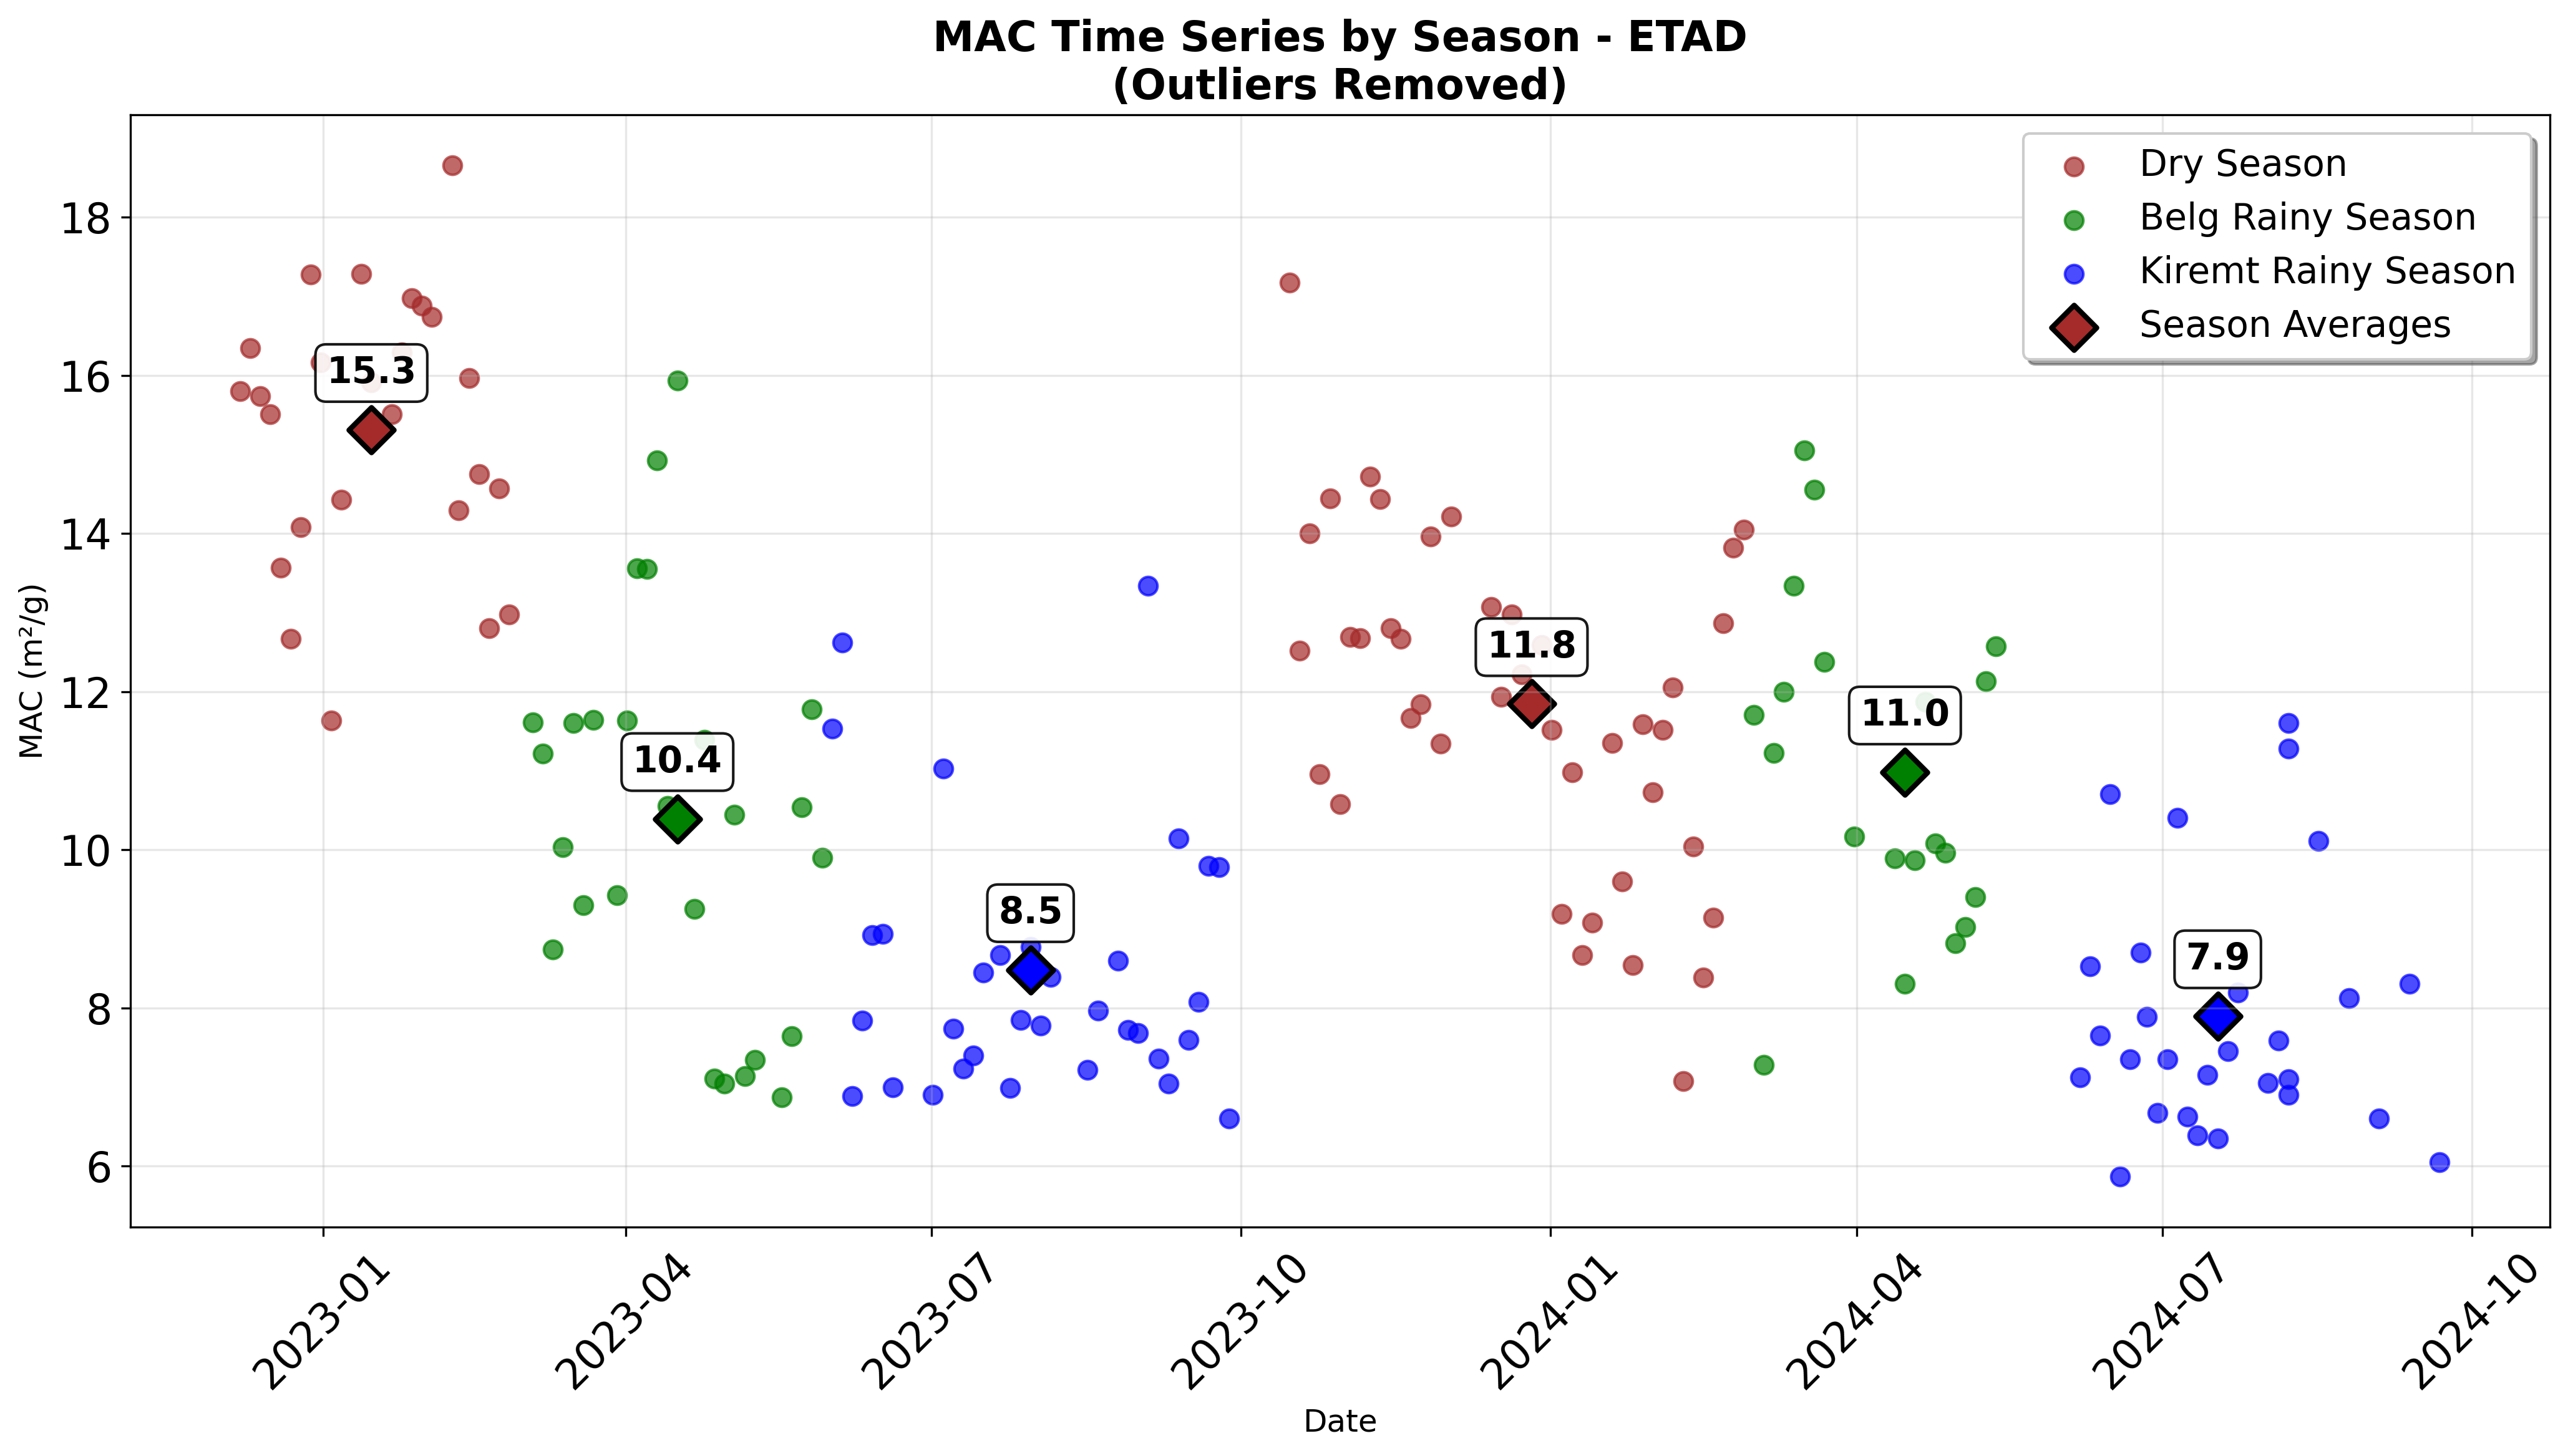


SEASONAL MAC COMPARISON

Season Instance Averages:
  Dry Season: 15.31 m²/g (n = 25)
  Dry Season: 11.84 m²/g (n = 42)
  Belg Rainy Season: 10.39 m²/g (n = 26)
  Belg Rainy Season: 10.98 m²/g (n = 20)
  Kiremt Rainy Season: 8.48 m²/g (n = 33)
  Kiremt Rainy Season: 7.90 m²/g (n = 28)

Overall MAC: 10.75 ± 3.04 m²/g (n = 174)

Season Ratios (relative to Dry Season):
  Belg Rainy Season: 0.81x
  Dry Season: 1.00x
  Kiremt Rainy Season: 0.63x

✅ Seasonal MAC analysis with instance averages complete!


In [11]:
# %% [markdown]
# ## Seasonal MAC Time Series Analysis
# 
# This section creates a time series visualization showing MAC values across Ethiopian seasons
# with cluster-based seasonal averages displayed as diamond markers.

# %%
def map_ethiopian_seasons(month):
    """Map month to Ethiopian season"""
    if month in [10, 11, 12, 1, 2]:
        return 'Dry Season'
    elif month in [3, 4, 5]:
        return 'Belg Rainy Season'
    else:
        return 'Kiremt Rainy Season'

def calculate_mac_values(df, mac_method='Method 4: Origin Regression'):
    """
    Calculate MAC values for each sample using the specified method
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Must contain 'ec_ftir' and 'fabs' columns
    mac_method : str
        Which method to use for MAC calculation
        
    Returns:
    --------
    pandas.DataFrame with added 'MAC' column
    """
    df_mac = df.copy()
    
    # Get the MAC value from the specified method
    mac_value = results['methods'][mac_method]['mac']
    
    # Calculate individual MAC values: MAC = Fabs / EC
    df_mac['MAC'] = df_mac['fabs'] / df_mac['ec_ftir']
    
    # Add month and season
    df_mac['month'] = df_mac['datetime_local'].dt.month
    df_mac['Ethiopian_Season'] = df_mac['month'].apply(map_ethiopian_seasons)
    
    print(f"\n{'='*70}")
    print(f"MAC VALUES CALCULATED")
    print(f"{'='*70}")
    print(f"Using {mac_method}")
    print(f"Reference MAC: {mac_value:.2f} m²/g")
    print(f"Individual MAC range: {df_mac['MAC'].min():.2f} - {df_mac['MAC'].max():.2f} m²/g")
    print(f"Mean MAC: {df_mac['MAC'].mean():.2f} ± {df_mac['MAC'].std():.2f} m²/g")
    
    return df_mac

# Calculate MAC values for each sample
df_with_mac = calculate_mac_values(df, mac_method='Method 4: Origin Regression')

# %%
def remove_mac_outliers(df, method='iqr'):
    """
    Remove MAC outliers using IQR method
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Must contain 'MAC' column
    method : str
        Outlier detection method ('iqr' or 'zscore')
        
    Returns:
    --------
    pandas.DataFrame with outliers removed
    """
    valid_mac = df[df['MAC'].notna()].copy()
    
    if method == 'iqr':
        Q1 = valid_mac['MAC'].quantile(0.25)
        Q3 = valid_mac['MAC'].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        print(f"\n{'='*70}")
        print(f"OUTLIER DETECTION (IQR Method)")
        print(f"{'='*70}")
        print(f"Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
        print(f"Outlier bounds: {lower_bound:.2f} - {upper_bound:.2f} m²/g")
        
        # Identify outliers
        outliers = valid_mac[(valid_mac['MAC'] < lower_bound) | (valid_mac['MAC'] > upper_bound)]
        
        if len(outliers) > 0:
            print(f"\nFound {len(outliers)} outlier(s):")
            for _, row in outliers.iterrows():
                print(f"  Date: {row['match_date']}, MAC: {row['MAC']:.2f} m²/g, Season: {row['Ethiopian_Season']}")
        
        # Remove outliers
        df_clean = valid_mac[(valid_mac['MAC'] >= lower_bound) & (valid_mac['MAC'] <= upper_bound)].copy()
        
        print(f"\nData summary:")
        print(f"  Original: {len(valid_mac)} samples")
        print(f"  After outlier removal: {len(df_clean)} samples")
        print(f"  Outliers removed: {len(outliers)}")
        
        return df_clean
    
    return valid_mac

# Remove outliers
df_clean = remove_mac_outliers(df_with_mac)

# %%
def plot_seasonal_mac_timeseries(valid_mac, site_code='ETAD'):
    """
    Create seasonal MAC time series visualization with cluster averages
    
    Parameters:
    -----------
    valid_mac : pandas.DataFrame
        Cleaned data with 'MAC', 'datetime_local', and 'Ethiopian_Season' columns
    site_code : str
        Site code for title
    """
    
    if len(valid_mac) > 0:
        # Create single time series plot
        fig, ax = plt.subplots(figsize=(14, 8))
        
        seasons_order = ['Dry Season', 'Belg Rainy Season', 'Kiremt Rainy Season']
        available_seasons = [s for s in seasons_order if s in valid_mac['Ethiopian_Season'].values]
        season_colors = {'Dry Season': 'brown', 'Belg Rainy Season': 'green', 'Kiremt Rainy Season': 'blue'}
        
        # First, plot all individual data points
        for season in available_seasons:
            season_data = valid_mac[valid_mac['Ethiopian_Season'] == season]
            if len(season_data) > 0:
                ax.scatter(season_data['datetime_local'], season_data['MAC'],
                           label=season, alpha=0.7, s=50,
                           color=season_colors.get(season, 'gray'))
        
        # Create seasonal clustering using date gaps to identify distinct seasonal periods
        season_averages = []
        
        for season in available_seasons:
            season_data = valid_mac[valid_mac['Ethiopian_Season'] == season].sort_values('datetime_local')
            
            if len(season_data) > 0:
                # Identify clusters within each season based on temporal gaps
                clusters = []
                current_cluster = [season_data.iloc[0]]
                
                for i in range(1, len(season_data)):
                    current_date = season_data.iloc[i]['datetime_local']
                    prev_date = season_data.iloc[i-1]['datetime_local']
                    
                    # If gap is more than 60 days, start a new cluster
                    if (current_date - prev_date).days > 60:
                        if len(current_cluster) >= 5:  # Only create average if cluster has ≥5 points
                            clusters.append(current_cluster)
                        current_cluster = [season_data.iloc[i]]
                    else:
                        current_cluster.append(season_data.iloc[i])
                
                # Don't forget the last cluster
                if len(current_cluster) >= 5:
                    clusters.append(current_cluster)
                
                # Create averages for each cluster
                for cluster in clusters:
                    cluster_df = pd.DataFrame(cluster)
                    avg_mac = cluster_df['MAC'].mean()
                    avg_date = cluster_df['datetime_local'].iloc[len(cluster_df)//2]  # median date
                    n_samples = len(cluster_df)
                    
                    season_averages.append({
                        'date': avg_date,
                        'season': season,
                        'avg_mac': avg_mac,
                        'n_samples': n_samples
                    })
        
        # Convert to DataFrame for easier plotting
        avg_df = pd.DataFrame(season_averages)
        
        # Plot the diamond markers with a single legend entry
        if len(avg_df) > 0:
            for i, (_, row) in enumerate(avg_df.iterrows()):
                # Only add legend label for the first diamond
                legend_label = "Season Averages" if i == 0 else ""
                
                ax.scatter(row['date'], row['avg_mac'],
                           alpha=1.0, s=150, marker='D',
                           color=season_colors.get(row['season'], 'gray'),
                           edgecolors='black', linewidth=2,
                           label=legend_label)
                
                # Add text labels showing the average value
                ax.annotate(f'{row["avg_mac"]:.1f}', 
                           (row['date'], row['avg_mac']),
                           xytext=(0, 15), textcoords='offset points',
                           ha='center', va='bottom', fontsize=14, fontweight='bold',
                           bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                                   alpha=0.9, edgecolor='black'))
        
        ax.set_title(f'MAC Time Series by Season - {site_code}\n(Outliers Removed)', 
                    fontsize=16, fontweight='bold')
        ax.set_xlabel('Date', fontsize=12)
        ax.set_ylabel('MAC (m²/g)', fontsize=12)
        ax.legend(loc='upper right', frameon=True, fancybox=True, shadow=True)
        ax.grid(True, alpha=0.3)
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        # Statistical comparison
        print(f"\n{'='*70}")
        print(f"SEASONAL MAC COMPARISON")
        print(f"{'='*70}")
        
        # Print season instance details
        if len(avg_df) > 0:
            print(f"\nSeason Instance Averages:")
            for _, row in avg_df.iterrows():
                print(f"  {row['season']}: {row['avg_mac']:.2f} m²/g (n = {row['n_samples']})")
        
        # Calculate overall statistics
        overall_mac = valid_mac['MAC']
        print(f"\nOverall MAC: {overall_mac.mean():.2f} ± {overall_mac.std():.2f} m²/g (n = {len(overall_mac)})")
        
        # Season-to-season ratios
        season_means = valid_mac.groupby('Ethiopian_Season')['MAC'].mean()
        print(f"\nSeason Ratios (relative to Dry Season):")
        if 'Dry Season' in season_means.index:
            dry_mean = season_means['Dry Season']
            for season in season_means.index:
                ratio = season_means[season] / dry_mean
                print(f"  {season}: {ratio:.2f}x")
        
        print(f"\n✅ Seasonal MAC analysis with instance averages complete!")
        
        return fig, avg_df
    else:
        print("❌ No valid MAC data for visualization")
        return None, None

# Create the seasonal time series plot
fig_seasonal, seasonal_averages = plot_seasonal_mac_timeseries(df_clean, site_code=SITE_CODE)

# %%
# Optional: Save the seasonal figure
# if fig_seasonal is not None:
#     output_filename = f'seasonal_mac_timeseries_{SITE_CODE}.png'
#     fig_seasonal.savefig(output_filename, dpi=300, bbox_inches='tight')
#     print(f"Seasonal figure saved to: {output_filename}")

In [9]:
def plot_method_agreement_timeseries(df, site_code='ETAD'):
    """
    Create time series comparison of Aethalometer, HIPS, and FTIR-EC measurements
    """
    
    print(f"\n{'='*70}")
    print(f"METHOD AGREEMENT ANALYSIS - THREE METHODS")
    print(f"{'='*70}")
    
    # Prepare comparison data
    comparison_data = df[['datetime_local', 'match_date', 'ec_ftir', 'fabs', 'ir_bcc']].copy()
    
    # Create HIPS MAC proxy
    comparison_data['HIPS_MAC_proxy'] = comparison_data['fabs'] / 10.0
    
    # Convert Aethalometer BCc from ng/m³ to μg/m³ if needed
    # Check the magnitude first
    if comparison_data['ir_bcc'].notna().sum() > 0:
        mean_bcc = comparison_data['ir_bcc'].mean()
        if mean_bcc > 100:  # Likely in ng/m³
            comparison_data['ir_bcc'] = comparison_data['ir_bcc'] / 1000.0
            print("Converted Aethalometer BCc from ng/m³ to μg/m³")
    
    # Count matched days
    all_methods_mask = comparison_data[['ir_bcc', 'HIPS_MAC_proxy', 'ec_ftir']].notna().all(axis=1)
    n_matched_days = all_methods_mask.sum()
    print(f"Days with all three methods: n = {n_matched_days}")
    
    # Create plot
    fig, ax = plt.subplots(figsize=(14, 8))
    
    method_info = {
        'ir_bcc': {'color': 'red', 'label': 'Aethalometer IR BCc', 'marker': 'o'},
        'HIPS_MAC_proxy': {'color': 'blue', 'label': 'HIPS using MAC of 10', 'marker': 's'}, 
        'ec_ftir': {'color': 'green', 'label': 'FTIR-EC', 'marker': '^'}
    }
    
    for method_col, info in method_info.items():
        mask = comparison_data[method_col].notna()
        if mask.sum() > 0:
            ax.plot(comparison_data.loc[mask, 'datetime_local'], 
                   comparison_data.loc[mask, method_col],
                   color=info['color'], marker=info['marker'], 
                   label=info['label'], alpha=0.8, markersize=6, linewidth=2,
                   markeredgecolor='white', markeredgewidth=0.5)
    
    ax.set_title(f'Method Agreement: Aethalometer vs HIPS vs FTIR-EC - {site_code}', 
                fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Date', fontsize=14, fontweight='bold')
    ax.set_ylabel('Concentration (μg/m³)', fontsize=14, fontweight='bold')
    ax.legend(loc='upper right', frameon=True, fancybox=True, shadow=True, fontsize=12)
    ax.grid(False)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    if n_matched_days > 0:
        print(f"\nMethod Means (n={n_matched_days} matched days):")
        print(f"  Aethalometer: {comparison_data.loc[all_methods_mask, 'ir_bcc'].mean():.2f} μg/m³")
        print(f"  HIPS (MAC=10): {comparison_data.loc[all_methods_mask, 'HIPS_MAC_proxy'].mean():.2f} μg/m³")
        print(f"  FTIR-EC:       {comparison_data.loc[all_methods_mask, 'ec_ftir'].mean():.2f} μg/m³")
    
    return fig, comparison_data


METHOD AGREEMENT ANALYSIS - THREE METHODS
Converted Aethalometer BCc from ng/m³ to μg/m³
Days with all three methods: n = 175


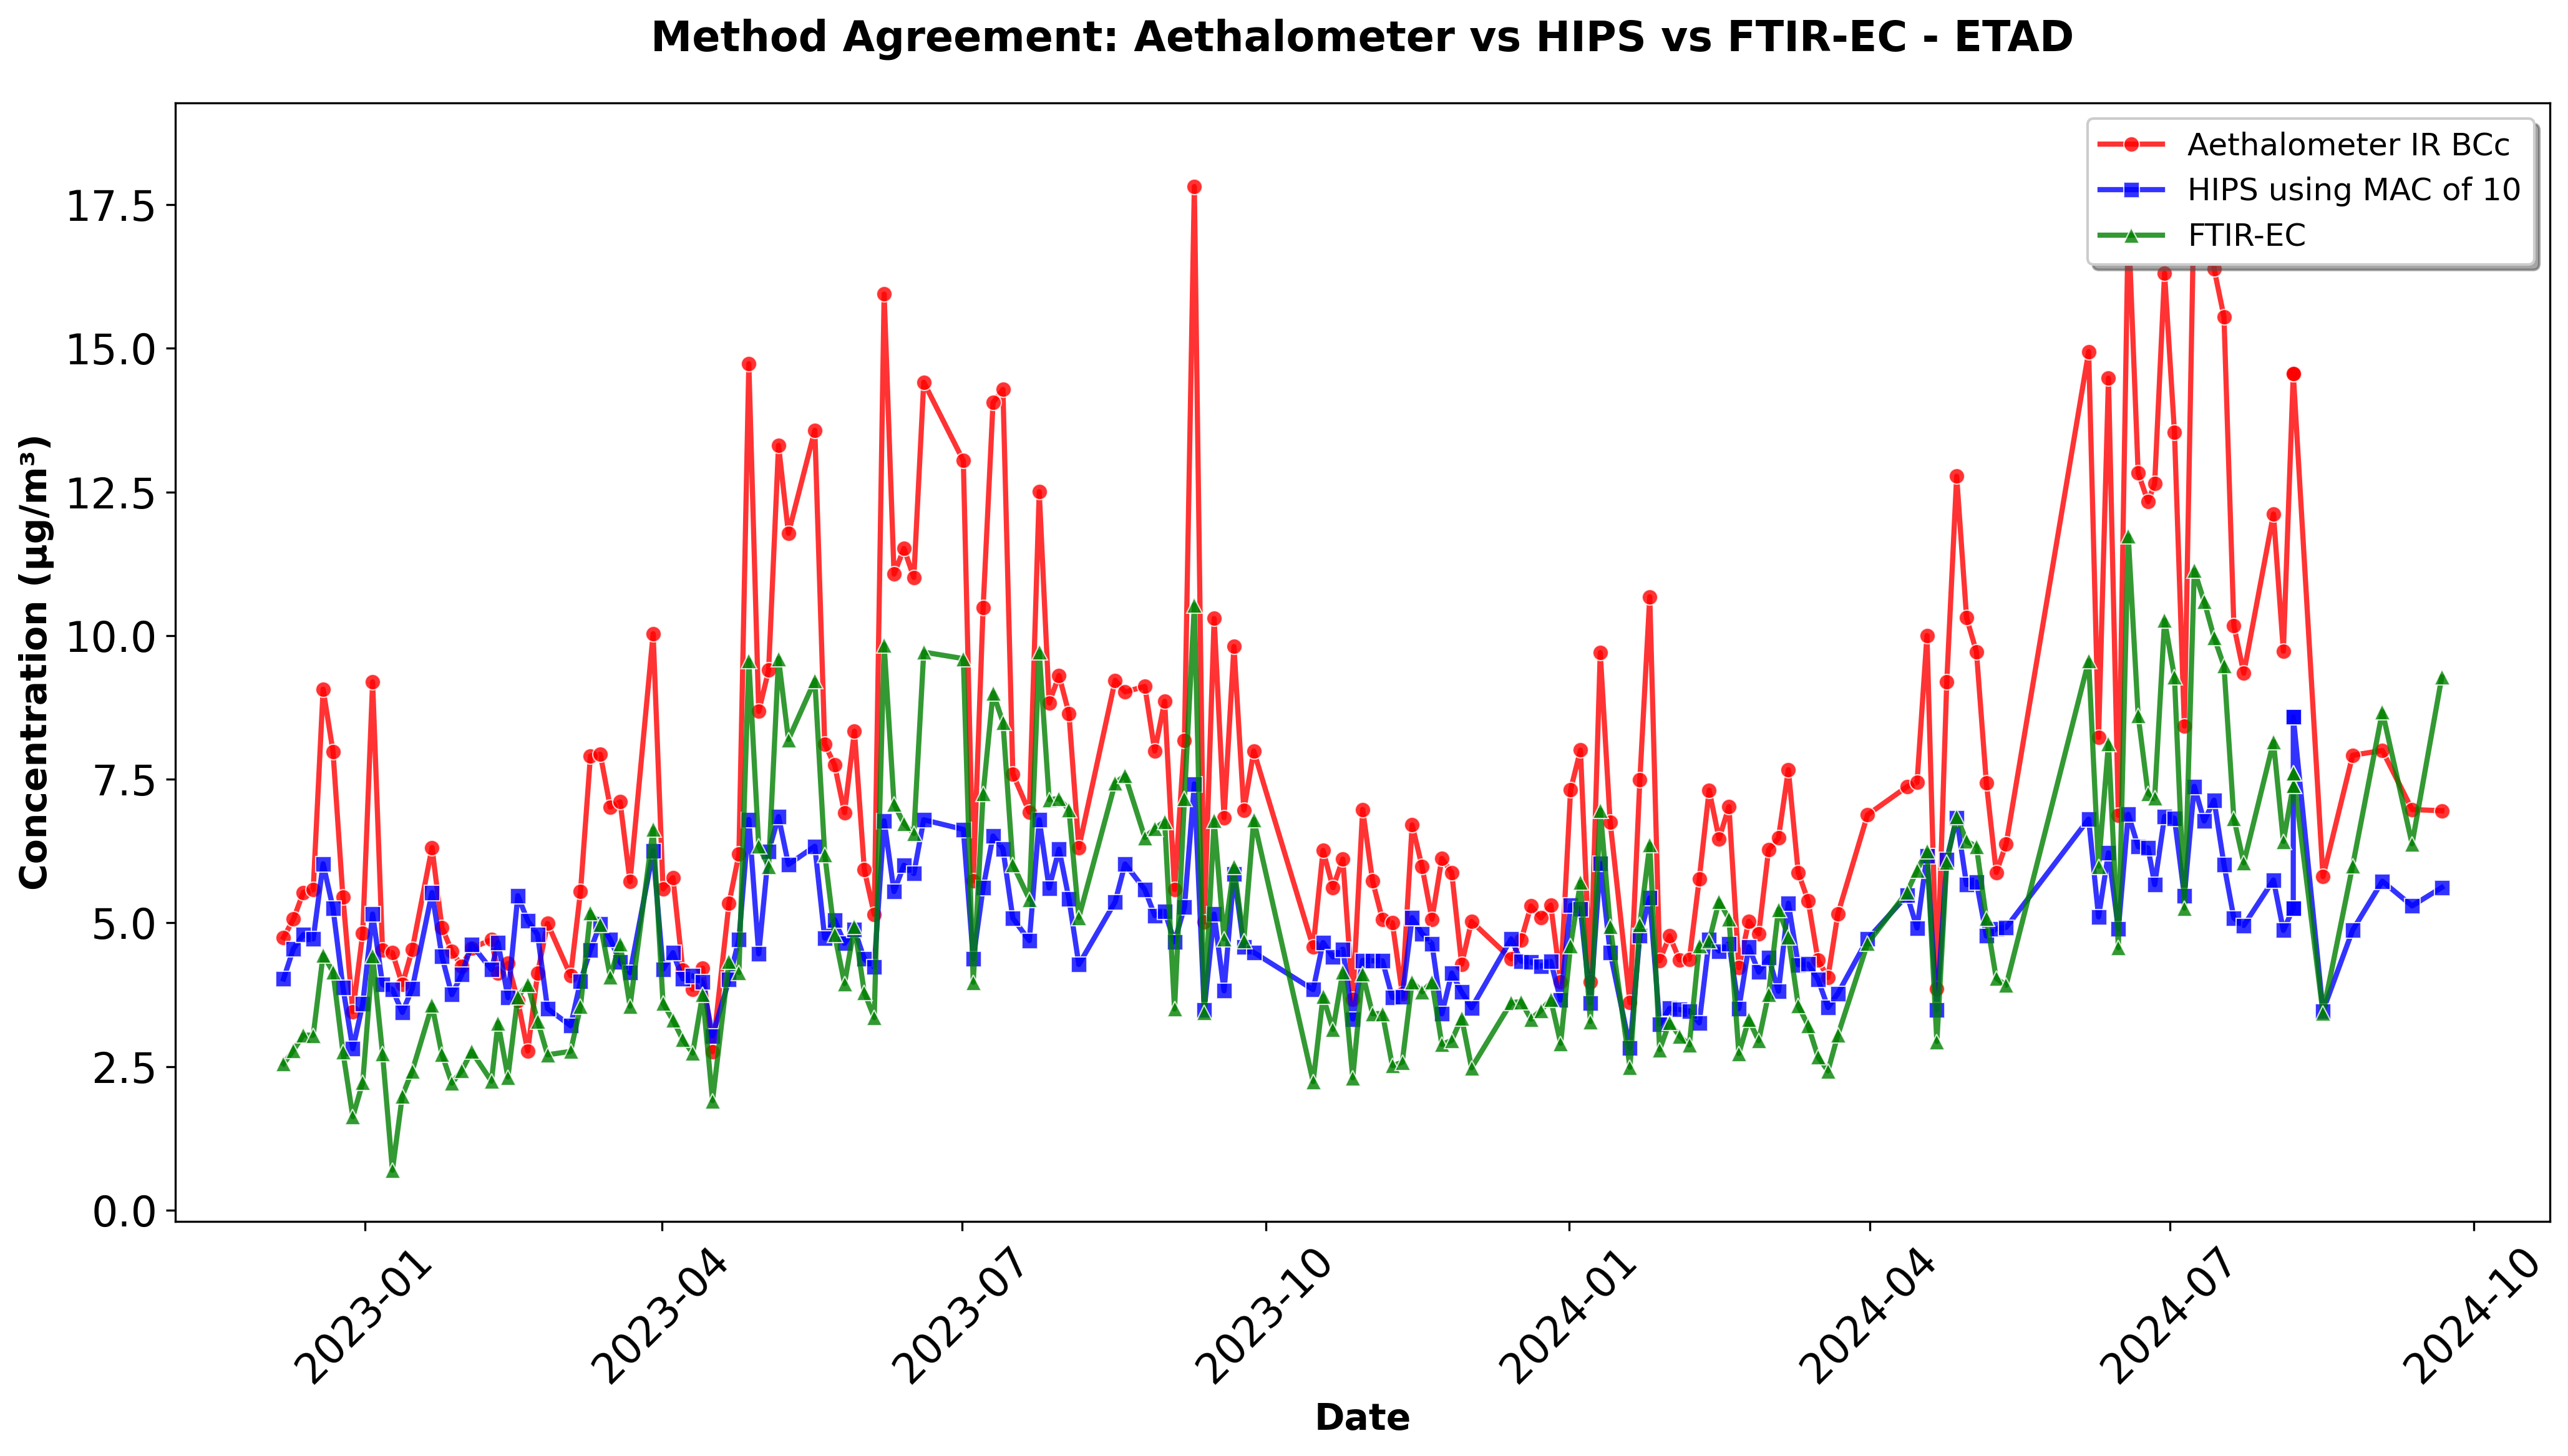


Method Means (n=175 matched days):
  Aethalometer: 7.79 μg/m³
  HIPS (MAC=10): 4.91 μg/m³
  FTIR-EC:       5.11 μg/m³


In [10]:
# Create the method agreement plot
fig_agreement, comparison_data = plot_method_agreement_timeseries(df, site_code=SITE_CODE)